In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import amlrealtimeai
from amlrealtimeai import resnet50

import h5py

In [2]:
# Input images as a two-dimensional tensor containing an arbitrary number of images represented a strings
import amlrealtimeai.resnet50.utils
in_images = tf.placeholder(tf.string)
image_tensors = resnet50.utils.preprocess_array(in_images)
image_tensors = tf.placeholder(tf.int32,shape=(None,224, 224, 3))

In [3]:
subscription_id = "80defacd-509e-410c-9812-6e52ed6a0016"
resource_group = "CMS_FPGA_Resources"
model_management_account = "CMS_FPGA_1"

from amlrealtimeai.resnet50.model import RemoteQuantizedResNet50
model_path = os.path.expanduser('~/models')
featurizer = RemoteQuantizedResNet50(subscription_id, resource_group, model_management_account, model_path)
print(featurizer.version)

Using TensorFlow backend.


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code ELTPCNHSD to authenticate.
1.1.6-rc


In [4]:
featurizer.import_graph_def(include_top=False, input_tensor=image_tensors)
features = featurizer.featurizer_output

Registering model resnet50-1.1.6-rc-model
Successfully registered model resnet50-1.1.6-rc-model
Creating service featurizer-service-08cdb9
. . . . . . . . 
Successfully created service featurizer-service-08cdb9


In [23]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load MNIST
f = h5py.File("//Users/atsaris/mygit_repos/ml_service/datasets/RandomData/hdf5/mnist_test.hdf5",'r')
images = np.array(f['features'])
#images = images.reshape(images.shape[0], images.shape[2], images.shape[3], images.shape[1])/255.
images = images.reshape(images.shape[0], images.shape[2], images.shape[3], images.shape[1]).astype('float32')
#print(images[0,:,:,-1].shape)
#plt.imshow(images[0,:,:,-1])
labels = np.array(f['targets'])
labels = labels.reshape(labels.shape[0])
f.close()

NUMBER_OF_DATA = 5000

# Reshape the image
images = images[:NUMBER_OF_DATA]
sess = tf.Session()
with sess.as_default():
    images_tf = tf.image.grayscale_to_rgb(images)
    images_tf = tf.image.resize_images(images_tf, [224,224])
    images = images_tf.eval()

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
    
# Extract features
feature_list = []
with tf.Session() as sess:
    for chunk in tqdm(chunks(images,50)):
        print(chunk.shape)
        result= sess.run([features],feed_dict={image_tensors:chunk})
        feature_list.extend(result[0])

feature_results = np.array(feature_list)
print(feature_results.shape)

0it [00:00, ?it/s]

(50, 224, 224, 3)


1it [00:16, 16.03s/it]

(50, 224, 224, 3)


2it [00:22, 11.16s/it]

(50, 224, 224, 3)


3it [00:28,  9.54s/it]

(50, 224, 224, 3)


4it [00:33,  8.37s/it]

(50, 224, 224, 3)


5it [00:39,  7.97s/it]

(50, 224, 224, 3)


6it [00:46,  7.73s/it]

(50, 224, 224, 3)


7it [00:52,  7.57s/it]

(50, 224, 224, 3)


8it [01:00,  7.59s/it]

(50, 224, 224, 3)


9it [01:06,  7.37s/it]

(50, 224, 224, 3)


10it [01:12,  7.23s/it]

(50, 224, 224, 3)


11it [01:18,  7.13s/it]

(50, 224, 224, 3)


12it [01:24,  7.05s/it]

(50, 224, 224, 3)


13it [01:30,  7.00s/it]

(50, 224, 224, 3)


14it [01:36,  6.92s/it]

(50, 224, 224, 3)


15it [01:43,  6.89s/it]

(50, 224, 224, 3)


16it [01:47,  6.73s/it]

(50, 224, 224, 3)


17it [01:52,  6.60s/it]

(50, 224, 224, 3)


18it [02:00,  6.71s/it]

(50, 224, 224, 3)


19it [02:05,  6.59s/it]

(50, 224, 224, 3)


20it [02:09,  6.50s/it]

(50, 224, 224, 3)


21it [02:16,  6.51s/it]

(50, 224, 224, 3)


22it [02:22,  6.49s/it]

(50, 224, 224, 3)


23it [02:31,  6.59s/it]

(50, 224, 224, 3)


24it [02:36,  6.53s/it]

(50, 224, 224, 3)


25it [02:43,  6.53s/it]

(50, 224, 224, 3)


26it [02:49,  6.53s/it]

(50, 224, 224, 3)


27it [02:56,  6.53s/it]

(50, 224, 224, 3)


28it [03:02,  6.52s/it]

(50, 224, 224, 3)


29it [03:09,  6.55s/it]

(50, 224, 224, 3)


30it [03:19,  6.63s/it]

(50, 224, 224, 3)


31it [03:24,  6.59s/it]

(50, 224, 224, 3)


32it [03:28,  6.52s/it]

(50, 224, 224, 3)


33it [03:34,  6.49s/it]

(50, 224, 224, 3)


34it [03:40,  6.48s/it]

(50, 224, 224, 3)


35it [03:47,  6.49s/it]

(50, 224, 224, 3)


36it [03:53,  6.49s/it]

(50, 224, 224, 3)


37it [03:58,  6.45s/it]

(50, 224, 224, 3)


38it [04:04,  6.43s/it]

(50, 224, 224, 3)


39it [04:09,  6.41s/it]

(50, 224, 224, 3)


40it [04:16,  6.40s/it]

(50, 224, 224, 3)


41it [04:22,  6.39s/it]

(50, 224, 224, 3)


42it [04:26,  6.35s/it]

(50, 224, 224, 3)


43it [04:32,  6.33s/it]

(50, 224, 224, 3)


44it [04:36,  6.29s/it]

(50, 224, 224, 3)


45it [04:43,  6.30s/it]

(50, 224, 224, 3)


46it [04:50,  6.31s/it]

(50, 224, 224, 3)


47it [05:09,  6.59s/it]

(50, 224, 224, 3)


48it [05:16,  6.59s/it]

(50, 224, 224, 3)


49it [05:22,  6.57s/it]

(50, 224, 224, 3)


50it [05:28,  6.57s/it]

(50, 224, 224, 3)


51it [05:34,  6.56s/it]

(50, 224, 224, 3)


52it [05:41,  6.57s/it]

(50, 224, 224, 3)


53it [05:48,  6.57s/it]

(50, 224, 224, 3)


54it [05:55,  6.58s/it]

(50, 224, 224, 3)


55it [06:02,  6.59s/it]

(50, 224, 224, 3)


56it [06:08,  6.58s/it]

(50, 224, 224, 3)


57it [06:16,  6.61s/it]

(50, 224, 224, 3)


58it [06:24,  6.63s/it]

(50, 224, 224, 3)


59it [06:32,  6.65s/it]

(50, 224, 224, 3)


60it [06:40,  6.67s/it]

(50, 224, 224, 3)


61it [06:48,  6.70s/it]

(50, 224, 224, 3)


62it [06:55,  6.71s/it]

(50, 224, 224, 3)


63it [07:01,  6.69s/it]

(50, 224, 224, 3)


64it [07:06,  6.67s/it]

(50, 224, 224, 3)


65it [07:12,  6.65s/it]

(50, 224, 224, 3)


66it [07:18,  6.64s/it]

(50, 224, 224, 3)


67it [07:24,  6.64s/it]

(50, 224, 224, 3)


68it [07:28,  6.60s/it]

(50, 224, 224, 3)


69it [07:34,  6.59s/it]

(50, 224, 224, 3)


70it [07:40,  6.58s/it]

(50, 224, 224, 3)


71it [07:45,  6.56s/it]

(50, 224, 224, 3)


72it [07:52,  6.56s/it]

(50, 224, 224, 3)


73it [07:58,  6.55s/it]

(50, 224, 224, 3)


74it [08:03,  6.54s/it]

(50, 224, 224, 3)


75it [08:10,  6.53s/it]

(50, 224, 224, 3)


76it [08:15,  6.52s/it]

(50, 224, 224, 3)


77it [08:19,  6.49s/it]

(50, 224, 224, 3)


78it [08:25,  6.48s/it]

(50, 224, 224, 3)


79it [08:33,  6.50s/it]

(50, 224, 224, 3)


80it [08:40,  6.51s/it]

(50, 224, 224, 3)


81it [08:50,  6.55s/it]

(50, 224, 224, 3)


82it [09:04,  6.64s/it]

(50, 224, 224, 3)


83it [09:10,  6.64s/it]

(50, 224, 224, 3)


84it [09:18,  6.65s/it]

(50, 224, 224, 3)


85it [09:26,  6.66s/it]

(50, 224, 224, 3)


86it [09:34,  6.68s/it]

(50, 224, 224, 3)


87it [09:41,  6.68s/it]

(50, 224, 224, 3)


88it [09:51,  6.72s/it]

(50, 224, 224, 3)


89it [10:06,  6.82s/it]

(50, 224, 224, 3)


90it [10:18,  6.87s/it]

(50, 224, 224, 3)


91it [10:28,  6.91s/it]

(50, 224, 224, 3)


92it [10:36,  6.92s/it]

(50, 224, 224, 3)


93it [10:42,  6.91s/it]

(50, 224, 224, 3)


94it [10:48,  6.90s/it]

(50, 224, 224, 3)


95it [10:59,  6.94s/it]

(50, 224, 224, 3)


96it [11:13,  7.02s/it]

(50, 224, 224, 3)


97it [11:22,  7.03s/it]

(50, 224, 224, 3)


98it [11:29,  7.04s/it]

(50, 224, 224, 3)


99it [11:34,  7.02s/it]

(50, 224, 224, 3)


100it [11:40,  7.00s/it]

(5000, 1, 1, 2048)


In [6]:
featurizer.cleanup_remote_service()

Deleting service 9314a29fa513404391d5253376260ee6
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Deleted service 9314a29fa513404391d5253376260ee6
Deleting model 48817cc95a84402580b1fd452a94affe
Deleted model 48817cc95a84402580b1fd452a94affe


In [24]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras import optimizers

FC_SIZE = 1024
NUM_CLASSES = 10

model = Sequential()
model.add(Dropout(0.2, input_shape=(1, 1, 2048,)))
model.add(Dense(FC_SIZE, activation='relu', input_dim=(1, 1, 2048,)))
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='sigmoid', input_dim=FC_SIZE))

model.compile(optimizer=optimizers.SGD(lr=1e-4,momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

onehot_labels = np_utils.to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(feature_results, onehot_labels[:NUMBER_OF_DATA], random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3750, 1, 1, 2048) (1250, 1, 1, 2048) (3750, 10) (1250, 10)


In [26]:
model.fit(X_train, y_train, epochs=16, batch_size=32)

Epoch 1/16
3750/3750 [==============================] - 1s 357us/step - loss: 0.4392 - acc: 0.8290
Epoch 2/16
3750/3750 [==============================] - 1s 302us/step - loss: 0.3307 - acc: 0.9001
Epoch 3/16
3750/3750 [==============================] - 1s 310us/step - loss: 0.3177 - acc: 0.8998
Epoch 4/16
3750/3750 [==============================] - 1s 296us/step - loss: 0.3063 - acc: 0.9000
Epoch 5/16
3750/3750 [==============================] - 1s 323us/step - loss: 0.2950 - acc: 0.9003
Epoch 6/16
3750/3750 [==============================] - 1s 315us/step - loss: 0.2855 - acc: 0.9006
Epoch 7/16
3750/3750 [==============================] - 1s 307us/step - loss: 0.2767 - acc: 0.9015
Epoch 8/16
3750/3750 [==============================] - 1s 344us/step - loss: 0.2691 - acc: 0.9037
Epoch 9/16
3750/3750 [==============================] - 1s 363us/step - loss: 0.2617 - acc: 0.9039
Epoch 10/16
3750/3750 [==============================] - 1s 348us/step - loss: 0.2566 - acc: 0.9051
Epoch 11/

In [27]:
from numpy import argmax

y_probs = model.predict(X_test)
y_prob_max = np.argmax(y_probs, 1)
y_test_max = np.argmax(y_test, 1)
print(y_probs)
print(y_prob_max)
print(y_test_max)

[[0.1560993  0.03441066 0.08566981 ... 0.03987736 0.09790856 0.25913006]
 [0.01599598 0.0183213  0.15232992 ... 0.05271259 0.05910967 0.03342381]
 [0.01837717 0.01035685 0.15882698 ... 0.06471109 0.02867143 0.02676922]
 ...
 [0.1105858  0.2316812  0.09542499 ... 0.10809521 0.10976887 0.138979  ]
 [0.01865262 0.13551237 0.04361216 ... 0.2581135  0.01753661 0.03760817]
 [0.09109724 0.03042813 0.26713908 ... 0.04508406 0.06173834 0.03381212]]
[9 3 3 ... 1 4 2]
[9 5 5 ... 9 7 2]


Accuracy 0.6936
Precision [0.65359477 0.7740113  0.47826087 0.52777778 0.83453237 0.71698113
 0.83783784 0.79381443 0.76515152 0.78512397]
Recall [0.96153846 0.99275362 0.69369369 0.84821429 0.8        0.27737226
 0.24409449 0.58778626 0.81451613 0.78512397]
F1 [0.77821012 0.86984127 0.56617647 0.65068493 0.81690141 0.4
 0.37804878 0.6754386  0.7890625  0.78512397]
Confusion Matrix [[100, 0, 1, 0, 1, 0, 0, 0, 0, 2], [0, 137, 0, 0, 0, 0, 0, 1, 0, 0], [8, 7, 77, 4, 0, 2, 1, 5, 5, 2], [0, 0, 7, 95, 0, 4, 1, 0, 4, 1], [1, 5, 12, 0, 116, 0, 0, 10, 0, 1], [5, 0, 18, 73, 0, 38, 0, 1, 1, 1], [31, 4, 19, 4, 1, 1, 31, 2, 20, 14], [1, 22, 14, 0, 16, 1, 0, 77, 0, 0], [2, 0, 8, 3, 0, 3, 2, 0, 101, 5], [5, 2, 5, 1, 5, 4, 2, 1, 1, 95]]


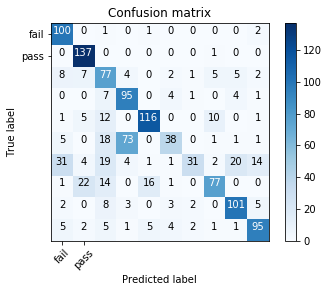

In [28]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import itertools
import matplotlib
from matplotlib import pyplot as plt

# compute a bunch of classification metrics 
def classification_metrics(y_true, y_pred, y_prob):
    cm_dict = {}
    cm_dict['Accuracy'] = accuracy_score(y_true, y_pred)
    cm_dict['Precision'] =  precision_score(y_true, y_pred, average=None)
    cm_dict['Recall'] =  recall_score(y_true, y_pred, average=None)
    cm_dict['F1'] =  f1_score(y_true, y_pred, average=None) 
    #cm_dict['AUC'] = roc_auc_score(y_true, y_prob[:,0])
    cm_dict['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    return cm_dict

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    New BSD License - see appendix
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0: cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cm_dict = classification_metrics(y_test_max, y_prob_max, y_probs)
for m in cm_dict:
    print(m, cm_dict[m])
cm = np.asarray(cm_dict['Confusion Matrix'])
plot_confusion_matrix(cm, ['fail','pass'], normalize=False)